All libraries imported successfully.
COCO annotation file loaded successfully.
Starting to extract bounding box dimensions...


100%|██████████| 76289/76289 [00:00<00:00, 1755561.97it/s]


A total of 76289 bounding boxes were extracted.

Starting K-means clustering with 9 clusters.


K-means Iteration: 100%|██████████| 100/100 [00:02<00:00, 47.88it/s]



K-means clustering complete!
Average IoU: 0.7424

Calculated optimal Anchor Box dimensions (width, height):
  - Width: 72.91, Height: 72.99, Area: 5321.72
  - Width: 174.69, Height: 50.60, Area: 8838.86
  - Width: 56.82, Height: 183.70, Area: 10439.01
  - Width: 106.12, Height: 106.85, Area: 11338.98
  - Width: 189.74, Height: 174.16, Area: 33045.97
  - Width: 215.98, Height: 303.98, Area: 65652.52
  - Width: 399.37, Height: 269.49, Area: 107625.25
  - Width: 344.53, Height: 421.72, Area: 145292.40
  - Width: 586.17, Height: 489.43, Area: 286889.88


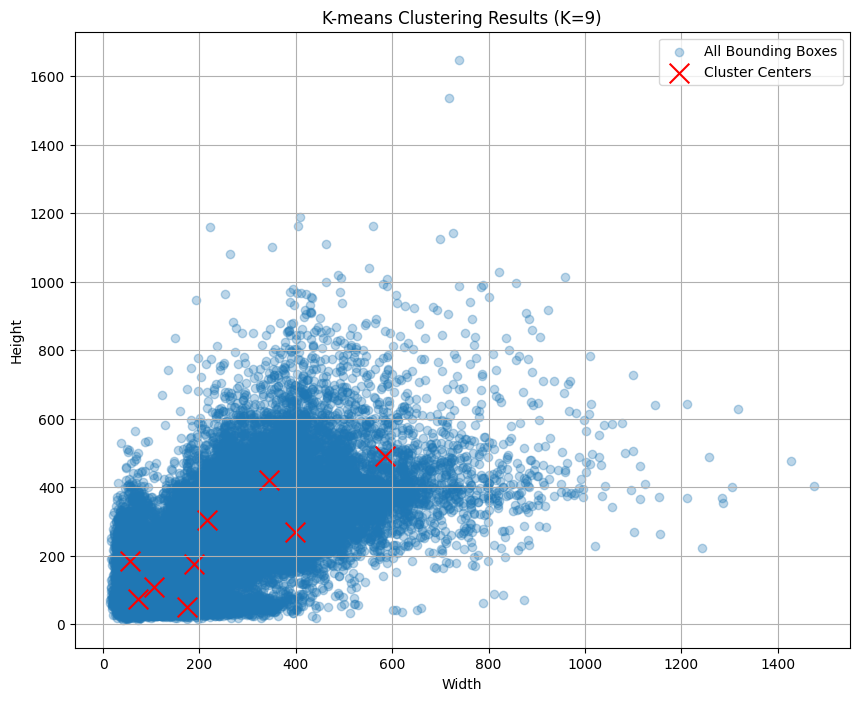


--- Further Analysis ---
Converting cluster centers to Aspect Ratios and Scales:
Calculated aspect ratios (ratios):
['1.00', '3.45', '0.31', '0.99', '1.09', '0.71', '1.48', '0.82', '1.20']

Calculated scales:
['0.32', '0.41', '0.45', '0.47', '0.79', '1.12', '1.43', '1.67', '2.34']


In [7]:
# bbox_kmeans_analysis.ipynb

# --- Import required libraries ---
import json
import numpy as np
# Replaced tqdm.notebook with tqdm
from tqdm import tqdm 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

print("All libraries imported successfully.")

# --- Define auxiliary function: IoU distance ---
def iou(boxes, clusters):
    """
    Calculates the IoU of all bounding boxes (boxes) with all cluster centers (clusters).
    boxes: NumPy array of shape (N, 2)
    clusters: NumPy array of shape (K, 2)
    """
    # Expand dimensions of boxes and clusters arrays for broadcasting
    box_w = boxes[:, np.newaxis, 0]
    box_h = boxes[:, np.newaxis, 1]
    cluster_w = clusters[np.newaxis, :, 0]
    cluster_h = clusters[np.newaxis, :, 1]

    # Calculate intersection area
    inter_w = np.minimum(box_w, cluster_w)
    inter_h = np.minimum(box_h, cluster_h)
    intersection = inter_w * inter_h

    # Calculate union area
    box_area = box_w * box_h
    cluster_area = cluster_w * cluster_h
    union = box_area + cluster_area - intersection

    # Avoid division by zero
    iou_scores = np.divide(intersection, union, out=np.zeros_like(intersection, dtype=float), where=union != 0)
    
    return iou_scores

# --- Define the K-means algorithm distance function ---
def kmeans_distance(boxes, clusters):
    """
    Calculates the distance of all bounding boxes (boxes) from all cluster centers (clusters).
    """
    return 1 - iou(boxes, clusters)

# --- Load COCO annotation file and extract all bounding box dimensions ---
json_path = '../data/processed/2.0-coco_annotations_cleaned.json'
try:
    with open(json_path, 'r') as f:
        coco_data = json.load(f)
    print("COCO annotation file loaded successfully.")

    bboxes = []
    print("Starting to extract bounding box dimensions...")
    # The tqdm here is also replaced accordingly
    for annotation in tqdm(coco_data['annotations']):
        bbox = annotation['bbox']  # [x, y, w, h]
        w, h = bbox[2], bbox[3]
        if w > 0 and h > 0:
            bboxes.append([w, h])
            
    bboxes = np.array(bboxes)
    print(f"A total of {len(bboxes)} bounding boxes were extracted.")

except FileNotFoundError:
    print(f"Error: File not found. Please check if the path is correct: {json_path}")
    bboxes = None

# --- K-means clustering ---

if bboxes is not None and len(bboxes) > 0:
    num_clusters = 9
    print(f"\nStarting K-means clustering with {num_clusters} clusters.")
    
    def run_kmeans(bboxes, num_clusters, max_iter=100, random_seed=42):
        np.random.seed(random_seed)
        
        indices = np.random.choice(len(bboxes), 1)
        clusters = bboxes[indices]
        for _ in range(1, num_clusters):
            distances = np.min(kmeans_distance(bboxes, clusters), axis=1)
            probabilities = distances / np.sum(distances)
            new_cluster_idx = np.random.choice(len(bboxes), 1, p=probabilities)[0]
            clusters = np.vstack([clusters, bboxes[new_cluster_idx]])
            
        # The tqdm here is also replaced accordingly
        for i in tqdm(range(max_iter), desc="K-means Iteration"):
            distances = kmeans_distance(bboxes, clusters)
            closest_cluster_indices = np.argmin(distances, axis=1)
            
            new_clusters = np.zeros((num_clusters, 2))
            for k in range(num_clusters):
                cluster_points = bboxes[closest_cluster_indices == k]
                if len(cluster_points) > 0:
                    new_clusters[k] = np.mean(cluster_points, axis=0)
            
            if np.all(clusters == new_clusters):
                break
            clusters = new_clusters
        
        avg_iou = np.mean(np.max(iou(bboxes, clusters), axis=1))
        
        return clusters, avg_iou

    clusters, avg_iou = run_kmeans(bboxes, num_clusters)

    print("\nK-means clustering complete!")
    print(f"Average IoU: {avg_iou:.4f}")
    print("\nCalculated optimal Anchor Box dimensions (width, height):")
    for w, h in sorted(clusters, key=lambda x: x[0] * x[1]):
        print(f"  - Width: {w:.2f}, Height: {h:.2f}, Area: {w*h:.2f}")

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.scatter(bboxes[:, 0], bboxes[:, 1], alpha=0.3, label='All Bounding Boxes')
    ax.scatter(clusters[:, 0], clusters[:, 1], c='red', marker='x', s=200, label='Cluster Centers')
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.set_title(f'K-means Clustering Results (K={num_clusters})')
    ax.legend()
    ax.grid(True)
    plt.show()
    
    print("\n--- Further Analysis ---")
    print("Converting cluster centers to Aspect Ratios and Scales:")
    
    sorted_clusters = sorted(clusters, key=lambda x: x[0] * x[1])
    
    ratios = [c[0] / c[1] for c in sorted_clusters]
    print("Calculated aspect ratios (ratios):")
    print([f"{r:.2f}" for r in ratios])
    
    areas = [c[0] * c[1] for c in sorted_clusters]
    base_size = np.mean(np.sqrt(areas))
    scales = [np.sqrt(area) / base_size for area in areas]
    print("\nCalculated scales:")
    print([f"{s:.2f}" for s in scales])

else:
    print("Cannot perform K-means clustering because no bounding box data is available.")